@LabName    :titanic  
@Author     :Сюй Цзэвень  
@Email      :xzw279135@gmail.com  
@Group      :11  
@Speciality :Информационная безопасность  

#PassengerId => 乘客ID  
#Pclass => 乘客等级(1/2/3等舱位)  
#Name => 乘客姓名  
#Sex => 性别  
#Age => 年龄  
#SibSp => 堂兄弟/妹个数  
#Parch => 父母与小孩个数  
#Ticket => 船票信息  
#Fare => 票价  
#Cabin => 客舱  
#Embarked => 登船港  

In [1]:

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest


In [2]:
input_df = pd.read_csv ( 'train.csv', header=0 )
submit_df = pd.read_csv ( 'test.csv', header=0 )

In [3]:
# Merge them
df = pd.concat ( [input_df, submit_df] )
# Rebuild index
df.reset_index ( inplace=True )
# Delete the "index column" generated by "reset_index()"
df.drop ( 'index', axis=1, inplace=True )
# View missing data in train.csv
print ( "查看train.csv中缺少数据：\n", input_df.isnull ().sum () )

查看train.csv中缺少数据：
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [4]:
print ( "查看test.csv中缺少数据：\n", submit_df.isnull ().sum () )

查看test.csv中缺少数据：
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
# View the merged data
print ( "查看合并后缺失的数据：\n", df.isnull ().sum () )

查看合并后缺失的数据：
 PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [6]:
# View INFO
print ( df.info () )
target_train = input_df['Survived']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


In [7]:
# Delete "Cabin','Ticket','PassengerId"，Not consider
df = df.drop ( ['Cabin', 'Ticket', 'PassengerId'], axis=1 )

c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


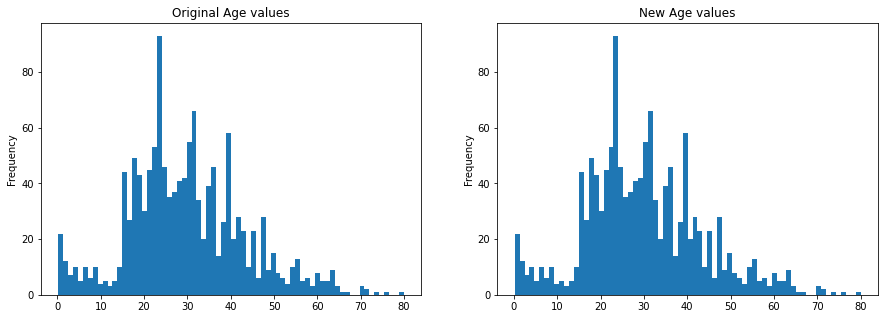

填充缺失值前： 263
填充缺失值后： 0


In [8]:
average_age   = df["Age"].mean()
std_age       = df["Age"].std()
count_nan_age = df["Age"].isnull().sum()
rand = np.random.randint(average_age - std_age, average_age + std_age, size = count_nan_age)
df['Age'][df.Age.isnull()] = rand
# chart
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
axis1.set_title('Original Age values')
axis2.set_title('New Age values')
df['Age'].plot(kind='hist', bins=70, ax=axis1)
df['Age'].plot(kind='hist', bins=70, ax=axis2)
plt.show()
print ( "填充缺失值前：", count_nan_age )
print ( "填充缺失值后：", df["Age"].isnull ().sum () )

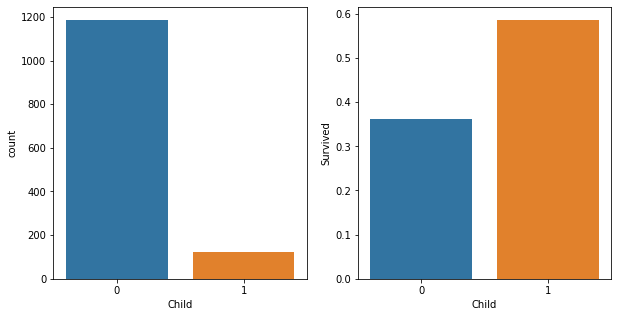

In [9]:
# Extract a feature from the age-"children"
def is_child(age):
    if age < 16:
        return 1
    else:
        return 0
# chart
df['Child'] = df['Age'].apply ( is_child )  # Less than 16
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='Child', data=df, ax=axis1)
child_survive = df[["Child", "Survived"]].groupby(['Child'],as_index=False).mean()
sns.barplot(x='Child', y='Survived', data=child_survive, ax=axis2)
plt.show()

c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


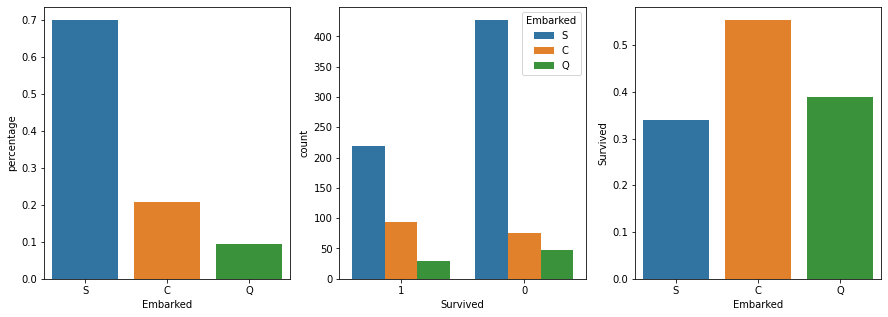

填充缺失值前： 2
填充缺失值后： 0


In [10]:
# Embarked => 登船港口:
# Embarked has only 2 missing items, fill it with the most common value directly, and then use the chart to see its relationship with Survived:
count_nan_age = df["Embarked"].isnull ().sum ()
df.Embarked[df.Embarked.isnull ()] = df.Embarked.dropna ().mode ().values
input_df_tmp = df[:input_df.shape[0]]  # Take out the input_df part, only they have the Survived feature.
(s, c, q) = df['Embarked'].value_counts ()

embark_percentage = pd.DataFrame ( {
    'Embarked': np.array ( ['S', 'C', 'Q'] ),
    'percentage': np.array ( [float ( i ) / df['Embarked'].count () for i in (s, c, q)] )} )
    
# chart
fig, (axis1, axis2, axis3) = plt.subplots ( 1, 3, figsize=(15, 5) )
sns.barplot ( x='Embarked', y='percentage', data=embark_percentage, ax=axis1 )
sns.countplot ( x='Survived', hue="Embarked", data=input_df_tmp, order=[1, 0], ax=axis2 )
embark_perc = input_df_tmp[["Embarked", "Survived"]].groupby ( ['Embarked'], as_index=False ).mean ()
sns.barplot ( x='Embarked', y='Survived', data=embark_perc, order=['S', 'C', 'Q'], ax=axis3 )
plt.show ()
print ( "填充缺失值前：", count_nan_age )
print ( "填充缺失值后：", df["Embarked"].isnull ().sum () )

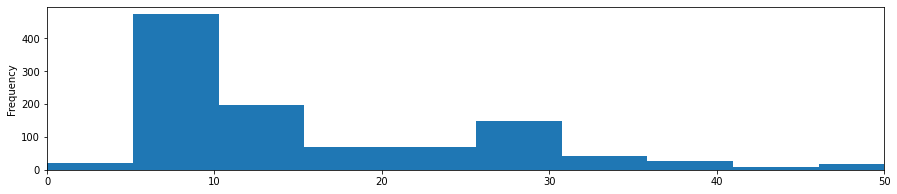

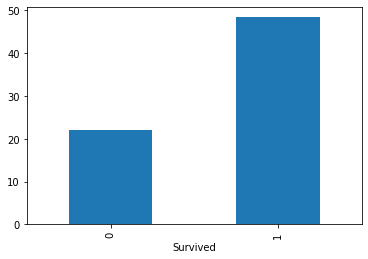

In [11]:
# Fare（票价）:
# Fare has only 1 missing item, fill it with the average
df["Fare"] = df["Fare"].fillna ( df["Fare"].median () )
# chart,Check their relationship
fare_not_survived = df["Fare"][df["Survived"] == 0]
fare_survived     = df["Fare"][df["Survived"] == 1]
avgerage_fare = pd.DataFrame ( [fare_not_survived.mean(), fare_survived.mean()] )
df['Fare'].plot(kind='hist', figsize=(15,3), bins=100, xlim=(0,50))
avgerage_fare.index.names =  ["Survived"]
avgerage_fare.plot(kind='bar', legend=False)
plt.show()

c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


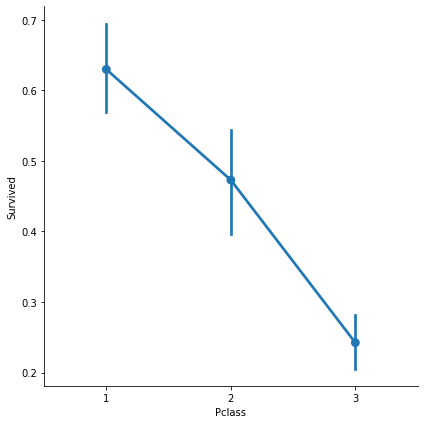

In [12]:
# 变量转换 Variable conversion
# Pclass => 乘客等级(1/2/3等舱位) ：
# chart
input_df_tmp = df[:input_df.shape[0]]
sns.factorplot('Pclass', 'Survived', order=[1,2,3], data=input_df_tmp, size=6)
plt.show()
# Pclass（客舱等级）考虑做Dummy Variables处理. Pclass, do Dummy Variables processing to make it generate more features.
pclass_dummies = pd.get_dummies ( df['Pclass'] )
pclass_dummies.columns = ['Class_1', 'Class_2', 'Class_3']
pclass_dummies.drop ( ['Class_3'], axis=1, inplace=True )
df.drop ( ['Pclass'], axis=1, inplace=True )
df = df.join ( pclass_dummies )

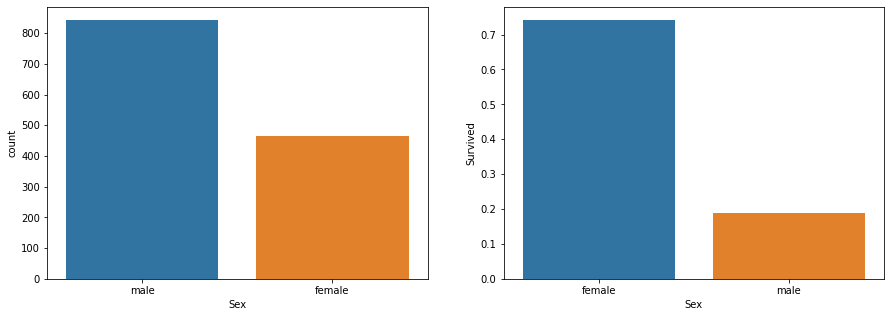

c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [13]:
# Sex:
# chart
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='Sex', data=df, ax=axis1)
women_survive = df[["Sex", "Survived"]].groupby(['Sex'],as_index=False).mean()
sns.barplot(x='Sex', y='Survived', data=women_survive, ax=axis2)
plt.show()
# Use numbers to represent Sex:
df['Sex'][df['Sex'] == 'male'] = 1
df['Sex'][df['Sex'] == 'female'] = 0
df['Sex'] = df['Sex'].astype ( int )

c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


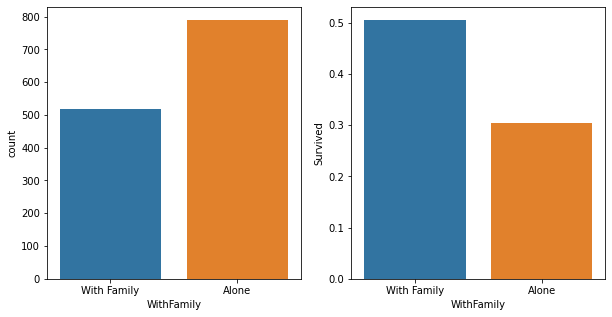

In [14]:
# Name
# Parch（父母/孩子的数量）
# SibSp（配偶的数量）：
# From this, we can extract the feature of whether they have family members on the ship,
# Because having family members means that there will be help from family members during the escape, and the survival rate may be higher.
df['WithFamily'] = df["Parch"] + df["SibSp"]
df['WithFamily'].loc[df['WithFamily'] > 1] = 1
df['WithFamily'].loc[df['WithFamily'] == 0] = 0
# chart
input_df_tmp = df[:input_df.shape[0]]
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))
sns.countplot(x='WithFamily', data=df, order=[1,0], ax=axis1)
family_perc = input_df_tmp[["WithFamily", "Survived"]].groupby(['WithFamily'],as_index=False).mean()
sns.barplot(x='WithFamily', y='Survived', data=family_perc, order=[1,0], ax=axis2)
axis1.set_xticklabels(["With Family","Alone"], rotation=0)
plt.show()


In [15]:
# Variable conversion
embark_dummies = pd.get_dummies ( df['Embarked'] )
df = df.join ( embark_dummies )
df.drop ( ['Embarked'], axis=1, inplace=True )

In [16]:
# Process the "last name"
df['Surname'] = df['Name'].map ( lambda x: re.compile (
    "(Mr|Mrs|Miss|Master|Don|Rev|Dr|Mme|Ms|Major|Lady|Sir|Mlle|Col|Capt|the Countess|Jonkheer|Dona)\.\s(\w*)" )
                                 .findall (x )[0][1] )
df['Surname'] = pd.factorize ( df['Surname'] )[0]

In [17]:
# Process the "titles"
df['Title'] = df['Name'].map ( lambda x: re.compile ( ", (.*?)\." ).findall ( x )[0] )
df['Title'][df.Title == 'Jonkheer'] = 'Master'
df['Title'][df.Title.isin ( ['Ms', 'Mlle'] )] = 'Miss'
df['Title'][df.Title == 'Mme'] = 'Mrs'
df['Title'][df.Title.isin ( ['Capt', 'Don', 'Major', 'Col', 'Sir'] )] = 'Sir'
df['Title'][df.Title.isin ( ['Dona', 'Lady', 'the Countess'] )] = 'Lady'
df['Title_id'] = pd.factorize ( df['Title'] )[0] + 1
df = df.drop ( ['Title'], axis=1 )
df.drop ( ['Name'], axis=1, inplace=True )

c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

In [18]:
# family size
df['FamilySize'] = df["Parch"] + df["SibSp"] + 1
df['FamilySize'].loc[df['FamilySize'] < 3] = 'small'
df['FamilySize'].loc[df['FamilySize'] != 'small'] = 'big'
df['FamilySize'][df['FamilySize'] == 'small'] = 0
df['FamilySize'][df['FamilySize'] == 'big'] = 1
df['FamilySize'] = df['FamilySize'].astype ( int )


c:\Users\XU\Documents\myproject\Machine learning\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
# Data needed for the model
df.drop ( ['Survived'], axis=1, inplace=True )
train_data = df[:input_df.shape[0]].values
train_target = target_train
test_data = df[input_df.shape[0]:].values

In [20]:
# 离差标准化数据 Standardized deviation data
train_data = MinMaxScaler ().fit_transform ( train_data )
test_data = MinMaxScaler ().fit_transform ( test_data )

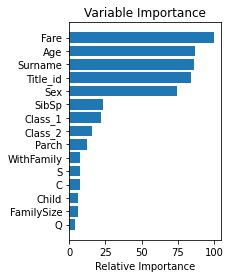

In [21]:
# 可视化研究不同特征的影响 Visualize the impact of different characteristics
import matplotlib.pyplot as plt
features_list = df.columns.values
# Fit a random forest with (mostly) default parameters to determine feature importance
forest = RandomForestClassifier(oob_score=True, n_estimators=10000)
forest.fit( train_data, train_target )
feature_importance = forest.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# Get the indexes of all features over the importance threshold
important_idx = np.where(feature_importance)[0]
# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
# print ("\nFeatures sorted by importance (DESC):\n", features_list[sorted_idx])
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, features_list[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [22]:
df.drop ( ['Q'], axis=1, inplace=True )

In [23]:
from sklearn.ensemble import RandomForestClassifier

# random_forest = RandomForestClassifier ( random_state=1, n_estimators=36,
#                                          min_samples_split=4, min_samples_leaf=2, max_depth=9 )
random_forest = RandomForestClassifier ( warm_start=True, random_state=1, n_estimators=26, max_depth=6,
max_features='sqrt', min_samples_split=4, min_samples_leaf=2 )

random_forest.fit ( train_data, train_target )
Y_pred = random_forest.predict ( test_data )
print ( random_forest.score ( train_data, train_target ) )
submission = pd.DataFrame ( {
    "PassengerId": submit_df["PassengerId"],
    "Survived": Y_pred.astype ( int )
} )
submission.to_csv ( 'result.csv', index=False )

0.8597081930415263
